# Procesado de los datos

Este paper tiene la finalidad de preprocesar los valores de generación de energía fotovoltaica del Centro de Investigación en Computación del Instituto Politécnico Nacional. La estrategia de pre procesado de datos es la siguiente

- Escoger días con puntos completos (que cuenten con los 288 puntos del día, ya que el intervalo de medición es de 5 minutos)
- Eliminar valores NaN de la serie
    - Obtener el intervalo de tiempos en los que se encuentran estos valores
    - Si pertenece a ese intervalo, se vuelve 0. Si no pertenece a ese intervalo, inputar el valor con la media de los n valores posteriores y anteriores
- Guardar los valores procesados en un archivo

In [41]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

CORR_THRESHOLD = 0.7

## Lectura de los datos

In [42]:
def read_data(year):
    folder = 'datos_SPV_det_anual-20240913T182932Z-001'
    nl_folder = 'datos_SPV_det_anual'
    
    return pd.read_excel(
    os.path.join(
        folder,
        nl_folder,
        str(year) + '_detallado.xlsx'
    ),
    skiprows = [1]
)

In [43]:
gen_df = pd.concat([
    read_data(2019),
    read_data(2020),
    read_data(2021),
    read_data(2022),
    read_data(2023),
])

## Filtrado de días con 288 puntos

In [44]:
gen_df = gen_df.assign(
    Fecha = gen_df['Fecha y hora'].apply(lambda x: str(x).split(' ')[0])
)

print('Filas antes de filtrar:', gen_df.shape[0], 'con', gen_df['Fecha'].nunique(), 'dias')

needed_values = 12 * 24
complete_dates = gen_df.groupby('Fecha').count().reset_index().query('`Fecha y hora` == @needed_values')['Fecha'].unique()
gen_df = gen_df[
    gen_df['Fecha'].isin(complete_dates)
]

print('Filas después de filtrar:', gen_df.shape[0], 'con', gen_df['Fecha'].nunique(), 'dias')

Filas antes de filtrar: 333775 con 1176 dias
Filas después de filtrar: 317088 con 1101 dias


In [45]:
def format_dates(dates):
    new_dates = []
    for date in dates:
        if('-' in str(date)):
            split_date = str(date).split('-')
            new_dates.append(
                split_date[2] + '.' + split_date[1] + '.' + split_date[0]
            )

        else:
            new_dates.append(date)

    return new_dates

formatted_dates = format_dates(gen_df['Fecha'].values)
gen_df = gen_df.assign(
    Fecha = formatted_dates
)

## Tratamiento de valores NaN

### ¿Cuántos valores NaN contienen los días?
Sacar el intervalo en el que hay valores de 0, si un NaN se encuentra en ese intervalo se imputa con 0, si se encuentra fuera de ese intervalo se imputa con la media del valor en t-1 y t+1

In [46]:
gen_df = gen_df.assign(
    Hora = gen_df['Fecha y hora'].apply(lambda x: str(x).split(' ')[1])
)

gen_df = gen_df.assign(
    Hora = gen_df['Hora'].apply(lambda x: str(x).split(':')[0] + ':' + str(x).split(':')[1])
)

zero_hours = sorted(pd.DataFrame(gen_df[
    gen_df['Producción fotovoltaica'] == 0
]['Hora'].value_counts()).reset_index().query('count > 3')['Hora'].values)

def impute_values(hours, productions, zero_hours):
    imputed_productions = productions

    for i in range(len(hours)):
        if(hours[i] in zero_hours and math.isnan(productions[i])):
            imputed_productions[i] = 0.0

        elif(hours[i] not in zero_hours and math.isnan(productions[i])):
            if(i == len(hours) - 1):
                imputed_productions[i] = productions[i - 1]
        
            else:
                if(math.isnan(imputed_productions[i + 1])):
                    imputed_productions[i] = productions[i - 1]
                
                else:
                    imputed_productions[i] = (productions[i - 1] + productions[i + 1]) / 2

        else:
            imputed_productions[i] = productions[i]

    return imputed_productions

new_productions = impute_values(
    gen_df['Hora'].values, gen_df['Producción fotovoltaica'].values, zero_hours
)

gen_df['Producción fotovoltaica'] = new_productions

In [47]:
zero_hours

['00:00',
 '00:05',
 '00:10',
 '00:15',
 '00:20',
 '00:25',
 '00:30',
 '00:35',
 '00:40',
 '00:45',
 '00:50',
 '00:55',
 '01:00',
 '01:05',
 '01:10',
 '01:15',
 '01:20',
 '01:25',
 '01:30',
 '01:35',
 '01:40',
 '01:45',
 '01:50',
 '01:55',
 '02:00',
 '02:05',
 '02:10',
 '02:15',
 '02:20',
 '02:25',
 '02:30',
 '02:35',
 '02:40',
 '02:45',
 '02:50',
 '02:55',
 '03:00',
 '03:05',
 '03:10',
 '03:15',
 '03:20',
 '03:25',
 '03:30',
 '03:35',
 '03:40',
 '03:45',
 '03:50',
 '03:55',
 '04:00',
 '04:05',
 '04:10',
 '04:15',
 '04:20',
 '04:25',
 '04:30',
 '04:35',
 '04:40',
 '04:45',
 '04:50',
 '04:55',
 '05:00',
 '05:05',
 '05:10',
 '05:15',
 '05:20',
 '05:25',
 '05:30',
 '05:35',
 '05:40',
 '05:45',
 '05:50',
 '05:55',
 '06:00',
 '06:05',
 '06:10',
 '06:15',
 '06:20',
 '06:25',
 '06:30',
 '06:35',
 '06:40',
 '06:45',
 '06:50',
 '06:55',
 '07:00',
 '07:05',
 '07:10',
 '07:15',
 '07:20',
 '07:25',
 '07:30',
 '07:35',
 '07:40',
 '17:35',
 '17:40',
 '17:45',
 '17:50',
 '17:55',
 '18:00',
 '18:05',


In [48]:
gen_df[
    gen_df['Producción fotovoltaica'].isna()
]

,Fecha y hora,Digital 1 | Sensor Card / Box (1),Digital 2 | Sensor Card / Box (1),Irradiación | Sensor Card / Box (1),Temperatura ambiente | Sensor Card / Box (1),Temperatura de módulo | Sensor Card / Box (1),Corriente CA L1 | Symo 22.7-3 480 (1),Corriente CA L1 | Symo 22.7-3 480 (Norte),Corriente CA L1 | Symo 22.7-3 480 (Sur),Corriente CA L2 | Symo 22.7-3 480 (1),...,Tensión CA L3 | Symo 22.7-3 480 (Sur),Tensión CC MPP1 | Symo 22.7-3 480 (1),Tensión CC MPP1 | Symo 22.7-3 480 (Norte),Tensión CC MPP1 | Symo 22.7-3 480 (Sur),Tensión CC MPP2 | Symo 22.7-3 480 (1),Tensión CC MPP2 | Symo 22.7-3 480 (Norte),Tensión CC MPP2 | Symo 22.7-3 480 (Sur),Producción fotovoltaica,Fecha,Hora


## Obtener características relevantes
Se obtendrán las columnas relevantes mediante la correlación entre las columnas y la producción fotovoltaica

In [49]:
dtypes_df = pd.DataFrame(gen_df.dtypes).reset_index()
dtypes_df.columns = ['column', 'dtype']
numeric_columns = dtypes_df[dtypes_df['dtype'] == 'float64']['column'].values

corr_df = gen_df[numeric_columns].corr().reset_index()
corr_df = corr_df[
    corr_df['index'] == 'Producción fotovoltaica'
].T.reset_index().iloc[1:]
corr_df.columns = ['column', 'correlation']
corr_df = corr_df[
    abs(corr_df['correlation']) > CORR_THRESHOLD
]
corr_df = corr_df.sort_values(by = 'correlation').reset_index(drop = True)

In [50]:
corr_df

,column,correlation
0,Potencia reactiva | Symo 22.7-3 480 (Norte),-0.85714
1,Potencia reactiva | Symo 22.7-3 480 (Sur),-0.79278
2,Temperatura de módulo | Sensor Card / Box (1),0.908048
3,Corriente CC MPP1 | Symo 22.7-3 480 (1),0.964973
4,Energía MPP1 | Symo 22.7-3 480 (1),0.968674
5,Irradiación | Sensor Card / Box (1),0.98559
6,Corriente CC MPP2 | Symo 22.7-3 480 (1),0.987772
7,Corriente CA L2 | Symo 22.7-3 480 (1),0.990479
8,Rendimiento específico | Symo 22.7-3 480 (1),0.990489
9,Energía | Symo 22.7-3 480 (1),0.990489


## Porcentaje de NaN

In [51]:
nan_percentages = []
for column in corr_df['column'].values:
    nan_percentages.append(gen_df[
        gen_df[column].isna()
    ].shape[0] / gen_df.shape[0])

pd.DataFrame(data = {
    'column': corr_df['column'].values,
    'nan_percentage': nan_percentages
}).sort_values(by = 'nan_percentage')

,column,nan_percentage
34,Producción fotovoltaica,0.000000
3,Corriente CC MPP1 | Symo 22.7-3 480 (1),0.065975
4,Energía MPP1 | Symo 22.7-3 480 (1),0.065975
6,Corriente CC MPP2 | Symo 22.7-3 480 (1),0.065975
7,Corriente CA L2 | Symo 22.7-3 480 (1),0.065975
8,Rendimiento específico | Symo 22.7-3 480 (1),0.065975
9,Energía | Symo 22.7-3 480 (1),0.065975
10,Potencia aparente | Symo 22.7-3 480 (1),0.065975
11,Corriente CA L1 | Symo 22.7-3 480 (1),0.065975
12,Corriente CA L3 | Symo 22.7-3 480 (1),0.065975


## Imputar NaN con mediana

In [52]:
final_df = gen_df[list(corr_df['column'].values) + ['Fecha', 'Hora']]
final_df.iloc[0] = [0] * (final_df.shape[1] - 2) + list(final_df.iloc[0, -2:].values)
final_df = final_df.fillna(method = 'ffill')
final_df

C:\Users\USER\AppData\Local\Temp\ipykernel_19400\2080449211.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df = final_df.fillna(method = 'ffill')


,Potencia reactiva | Symo 22.7-3 480 (Norte),Potencia reactiva | Symo 22.7-3 480 (Sur),Temperatura de módulo | Sensor Card / Box (1),Corriente CC MPP1 | Symo 22.7-3 480 (1),Energía MPP1 | Symo 22.7-3 480 (1),Irradiación | Sensor Card / Box (1),Corriente CC MPP2 | Symo 22.7-3 480 (1),Corriente CA L2 | Symo 22.7-3 480 (1),Rendimiento específico | Symo 22.7-3 480 (1),Energía | Symo 22.7-3 480 (1),...,Corriente CA L3 | Symo 22.7-3 480 (Norte),Corriente CA L2 | Symo 22.7-3 480 (Norte),Energía MPP1 | Symo 22.7-3 480 (Norte),Potencia aparente | Symo 22.7-3 480 (Norte),Rendimiento específico | Symo 22.7-3 480 (Norte),Energía | Symo 22.7-3 480 (Norte),Energía MPP2 | Symo 22.7-3 480 (Norte),Producción fotovoltaica,Fecha,Hora
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:00
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:05
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:10
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:15
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100493,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:35
100494,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:40
100495,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:45
100496,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:50


In [53]:
final_df.describe()[
    ['Potencia reactiva | Symo 22.7-3 480 (Norte)',
       'Potencia reactiva | Symo 22.7-3 480 (Sur)',
       'Temperatura de módulo | Sensor Card / Box (1)',
       'Irradiación | Sensor Card / Box (1)',
       'Energía | Symo 22.7-3 480 (1)'

]]

,Potencia reactiva | Symo 22.7-3 480 (Norte),Potencia reactiva | Symo 22.7-3 480 (Sur),Temperatura de módulo | Sensor Card / Box (1),Irradiación | Sensor Card / Box (1),Energía | Symo 22.7-3 480 (1)
count,317088.000000,317088.000000,317088.000000,317088.000000,317088.000000
mean,-7.953227,-3.132833,25.812104,199.773331,204.156066
std,36.524708,40.943096,12.551188,289.796911,302.065523
min,-146.400000,-151.710000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,17.000000,0.000000,0.000000
50%,0.000000,0.000000,21.000000,0.000000,0.000000
75%,7.530000,28.270000,34.000000,367.000000,376.883570
max,62.240000,75.130000,63.000000,1255.000000,1634.775880


In [54]:
final_df.to_csv('Processed data.csv', index = False)

# Descriptiva de los datos

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

final_df = pd.read_csv('Processed data.csv')
final_df

,Potencia reactiva | Symo 22.7-3 480 (Norte),Potencia reactiva | Symo 22.7-3 480 (Sur),Temperatura de módulo | Sensor Card / Box (1),Corriente CC MPP1 | Symo 22.7-3 480 (1),Energía MPP1 | Symo 22.7-3 480 (1),Irradiación | Sensor Card / Box (1),Corriente CC MPP2 | Symo 22.7-3 480 (1),Corriente CA L2 | Symo 22.7-3 480 (1),Rendimiento específico | Symo 22.7-3 480 (1),Energía | Symo 22.7-3 480 (1),...,Corriente CA L3 | Symo 22.7-3 480 (Norte),Corriente CA L2 | Symo 22.7-3 480 (Norte),Energía MPP1 | Symo 22.7-3 480 (Norte),Potencia aparente | Symo 22.7-3 480 (Norte),Rendimiento específico | Symo 22.7-3 480 (Norte),Energía | Symo 22.7-3 480 (Norte),Energía MPP2 | Symo 22.7-3 480 (Norte),Producción fotovoltaica,Fecha,Hora
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:05
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:15
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.10.2019,00:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317083,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:35
317084,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:40
317085,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:45
317086,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.12.2023,23:50


In [49]:
final_df['Fecha'].nunique()

1101

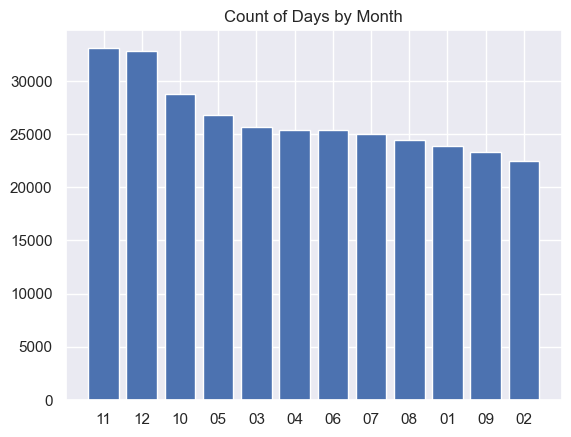

In [50]:
final_df = final_df.assign(
    Mes = final_df['Fecha'].apply(lambda x: str(x).split('.')[1]),
    Dia = final_df['Fecha'].apply(lambda x: int(str(x).split('.')[0]))
)

plt.title("Count of Days by Month")
plt.bar(
    list(final_df['Mes'].value_counts().index),
    list(final_df['Mes'].value_counts().values)
);

In [51]:
spring_df = final_df[
    ((final_df['Mes'] == '03') & (final_df['Dia'] > 20)) |
    ((final_df['Mes'] == '06') & (final_df['Dia'] <= 21))
]

summer_df = final_df[
    ((final_df['Mes'] == '06') & (final_df['Dia'] > 21)) |
    ((final_df['Mes'] == '09') & (final_df['Dia'] <= 23))
]

autumn_df = final_df[
    ((final_df['Mes'] == '09') & (final_df['Dia'] > 23)) |
    ((final_df['Mes'] == '12') & (final_df['Dia'] <= 21))
]

winter_df = final_df[
    ((final_df['Mes'] == '12') & (final_df['Dia'] > 21)) |
    ((final_df['Mes'] == '03') & (final_df['Dia'] <= 20))
]

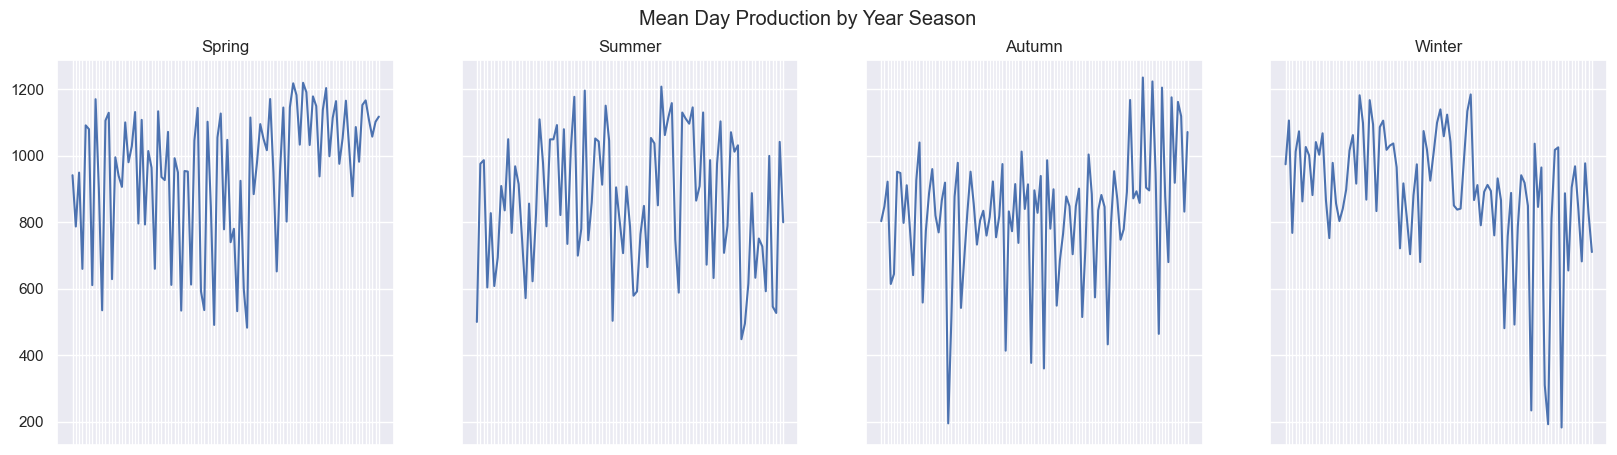

In [52]:
fig, axes = plt.subplots(1, 4, figsize = (20, 5), sharey = True)
fig.suptitle("Mean Day Production by Year Season")

axes[0].set_xticklabels([])
axes[0].title.set_text('Spring')
axes[0].plot(spring_df.groupby('Fecha')['Producción fotovoltaica'].mean())

axes[1].set_xticklabels([])
axes[1].title.set_text('Summer')
axes[1].plot(summer_df.groupby('Fecha')['Producción fotovoltaica'].mean())

axes[2].set_xticklabels([])
axes[2].title.set_text('Autumn')
axes[2].plot(autumn_df.groupby('Fecha')['Producción fotovoltaica'].mean())

axes[3].set_xticklabels([])
axes[3].title.set_text('Winter')
axes[3].plot(winter_df.groupby('Fecha')['Producción fotovoltaica'].mean());

# Time series

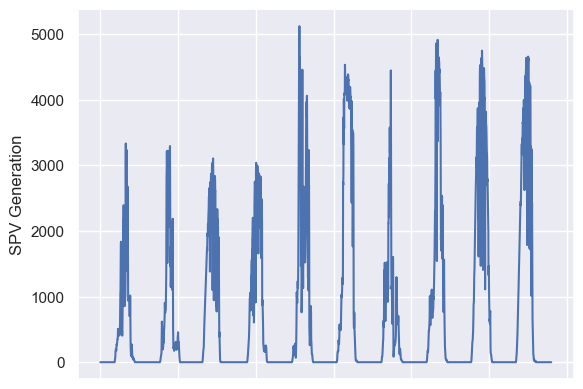

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

ax = sns.lineplot(final_df['Producción fotovoltaica'].iloc[:2900])
ax.set(ylabel = 'SPV Generation', xticklabels = []);

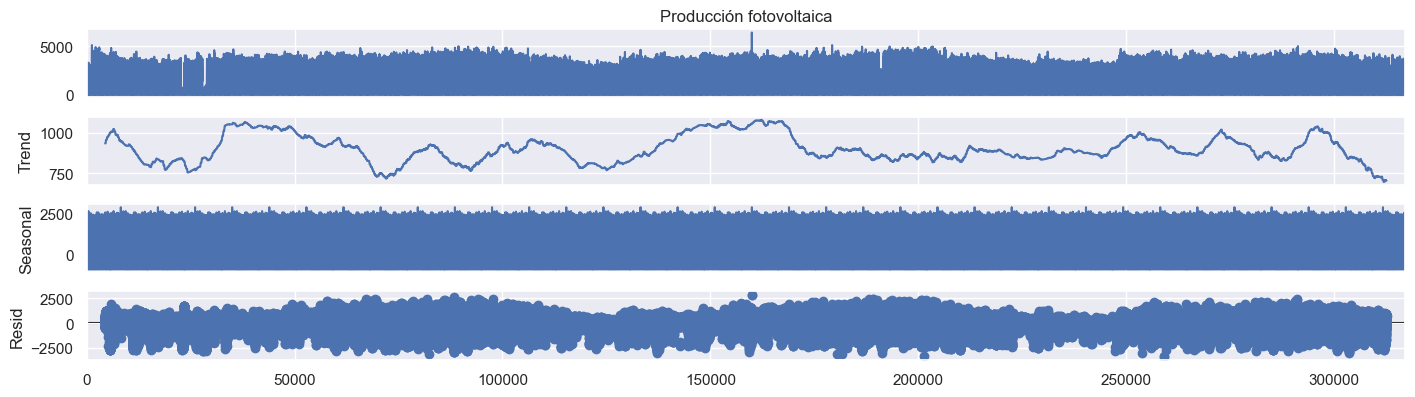

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 288 * 31 number of points in one month
decompose = seasonal_decompose(final_df['Producción fotovoltaica'], model = 'additive', period = 8928)
fig = decompose.plot()
fig.set_size_inches(16, 4)
#fig.suptitle('SPV Generation Decomposition')
plt.show()

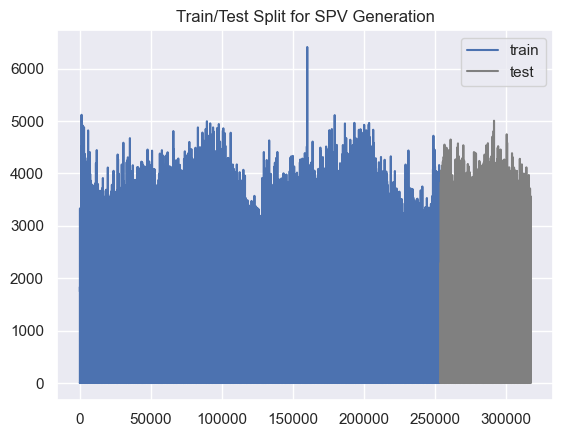

In [55]:
total_rows = final_df.shape[0]
split_index = int(total_rows * 0.8)
train_df = final_df.iloc[0:split_index]
test_df = final_df.iloc[split_index:]

plt.plot(train_df['Producción fotovoltaica'], label = 'train')
plt.plot(test_df['Producción fotovoltaica'], color = 'gray', label = 'test')
plt.legend()
plt.title('Train/Test Split for SPV Generation');

In [110]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(endog = final_df['Producción fotovoltaica'], order = (1, 1, 1))
model_fit = model.fit()
predictions = model_fit.predict(start = train_df.index[-1], end = test_df.index[-1])

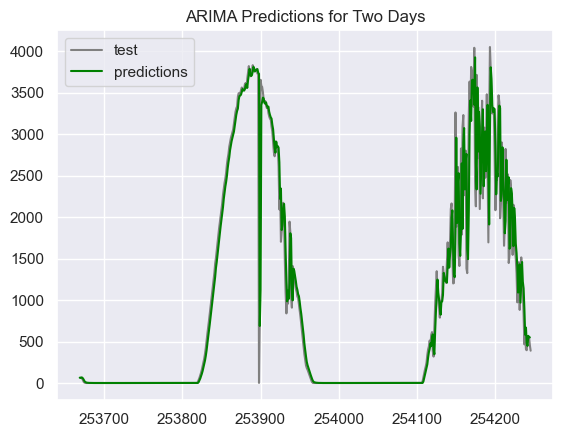

In [117]:
#plt.plot(train_df['Producción fotovoltaica'], label = 'train')
plt.plot(test_df['Producción fotovoltaica'].iloc[:288 * 2], color = 'gray', label = 'test')
plt.plot(predictions[:288 * 2], color = 'green', label = 'predictions')
plt.legend()
plt.title('ARIMA Predictions for Two Days');

In [119]:
from sklearn.metrics import mean_squared_error 

mean_squared_error(test_df['Producción fotovoltaica'], predictions[:-1])

143068.888098409

# LSTM

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [57]:
# create and fit the LSTM network
look_back = 1
train_y = train_df['Producción fotovoltaica']
del train_df['Producción fotovoltaica']
del train_df['Fecha']
del train_df['Hora']
del train_df['Mes']
train_X = train_df.copy()

test_y = test_df['Producción fotovoltaica']
del test_df['Producción fotovoltaica']
del test_df['Fecha']
del test_df['Hora']
del test_df['Mes']
test_X = test_df.copy()

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model = Sequential()
model.add(LSTM(4, input_shape = (1, 1), activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_X, train_y, epochs = 100, batch_size = 128, verbose = 2)

Epoch 1/100


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1982/1982 - 10s - 5ms/step - loss: 1190301.3750
Epoch 2/100
1982/1982 - 8s - 4ms/step - loss: 1149029.7500
Epoch 3/100
1982/1982 - 8s - 4ms/step - loss: 27479.3828
Epoch 4/100
1982/1982 - 8s - 4ms/step - loss: 24693.7051
Epoch 5/100
1982/1982 - 8s - 4ms/step - loss: 20802.5996
Epoch 6/100
1982/1982 - 9s - 4ms/step - loss: 21216.1445
Epoch 7/100
1982/1982 - 8s - 4ms/step - loss: 18485.9453
Epoch 8/100
1982/1982 - 8s - 4ms/step - loss: 15402.7969
Epoch 9/100
1982/1982 - 8s - 4ms/step - loss: 13999.6396
Epoch 10/100
1982/1982 - 9s - 4ms/step - loss: 11169.8760
Epoch 11/100
1982/1982 - 9s - 4ms/step - loss: 12052.0977
Epoch 12/100
1982/1982 - 8s - 4ms/step - loss: 13601.5879
Epoch 13/100
1982/1982 - 8s - 4ms/step - loss: 15646.6582
Epoch 14/100
1982/1982 - 9s - 4ms/step - loss: 11948.5244
Epoch 15/100
1982/1982 - 8s - 4ms/step - loss: 8883.2217
Epoch 16/100
1982/1982 - 8s - 4ms/step - loss: 9280.0986
Epoch 17/100
1982/1982 - 8s - 4ms/step - loss: 9436.9854
Epoch 18/100
1982/1982 - 8s - 4ms

In [63]:
mean_squared_error(test_y, model.predict(test_X))

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


571.852045061752

In [74]:
plt.plot(test_y[:288 * 2].values, color = 'gray', label = 'test')
plt.plot(model.predict(test_X)[:288 * 2], color = 'green', label = 'predictions')
plt.legend()
plt.title('LSTM Predictions for Two Days');

 245/1982 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

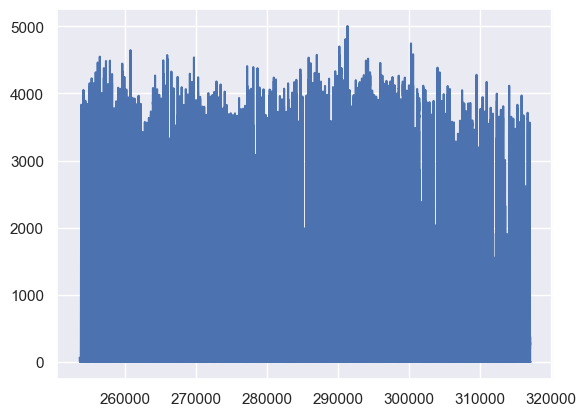

In [72]:
plt.plot(test_y)

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


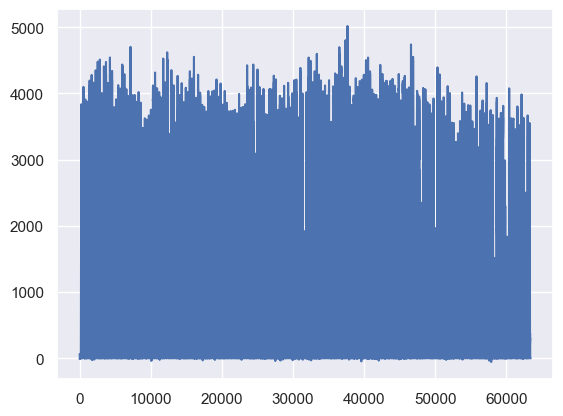

In [73]:
plt.plot(model.predict(test_X))